# CPW Resonator properties

## Imports

In [163]:
from scipy.special import ellipk
import math
from tabulate import tabulate
import numpy as np
import cmath

import matplotlib.pyplot as plt
%matplotlib inline

## Classes

In [164]:
class Conductor:
    """CPW conductor material class"""

    def __init__(self, material, criticalTemperature, londonPenetrationDepthZero, resistancePerUnitLength,
                 conductancePerUnitLength, amplitudeAttenuationPerUnitLength):
        self.material = material
        self.criticalTemperature = criticalTemperature
        self.londonPenetrationDepthZero = londonPenetrationDepthZero
        self.resistancePerUnitLength = resistancePerUnitLength
        self.conductancePerUnitLength = conductancePerUnitLength
        self.amplitudeAttenuationPerUnitLength = amplitudeAttenuationPerUnitLength

In [165]:
class Substrate:
    """Substrate material class"""

    def __init__(self, material, relativePermittivity):
        self.material = material
        self.relativePermittivity = relativePermittivity

In [219]:
class CPWResonator:
    """Coplanar wave-guide resonator class"""

    def __init__(self, length, conductorWidth, gapWidth, conductorThickness, resonatorType,
                 conductorMaterial='Niobium', substrateMaterial='Silicon',
                 temperature=4, couplingCapacitance=0E0, loadImpedance=50, loadBoundaryCondition='Short', modes=1):
        # Supplied parameters
        self.length = np.array(length)
        self.conductorWidth = np.array(conductorWidth)
        self.gapWidth = np.array(gapWidth)
        self.conductorThickness = np.array(conductorThickness)
        self.resonatorType = np.array(resonatorType)
        self.conductor = self.conductorProperties(conductorMaterial)
        self.substrate = self.substrateProperties(substrateMaterial)
        self.temperature = np.array(temperature)
        self.couplingCapacitance = np.array(couplingCapacitance)
        self.loadImpedance = np.array(loadImpedance)
        self.loadBoundaryCondition = np.array(loadBoundaryCondition)
        self.modes = np.array(modes)

        # Calculated parameters
        self.effectivePermittivity = self.effectivePermittivity(self.substrate.relativePermittivity)
        self.capacitancePerUnitLength = self.capacitancePerUnitLength(self.conductorWidth, self.gapWidth, self.effectivePermittivity)
        self.geometricInducatancePerUnitLength = self.geometricInducatancePerUnitLength(self.conductorWidth, self.gapWidth)
        self.kineticInductancePerUnitLength = self.kineticInductancePerUnitLength(self.conductorWidth, self.gapWidth, self.conductorThickness,
            self.temperature, self.conductor.criticalTemperature, self.conductor.londonPenetrationDepthZero)
        self.totalInductancePerUnitLength = self.geometricInducatancePerUnitLength + self.kineticInductancePerUnitLength
        self.characteristicImpedance = self.characteristicImpedance(self.totalInductancePerUnitLength, self.capacitancePerUnitLength)
        self.uncoupledResonantFrequency = self.uncoupledResonantFrequency(self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.length,
            self.resonatorType, self.modes)
        self.coupledResonantFrequency = self.coupledResonantFrequency(self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.length,
            self.resonatorType, self.couplingCapacitance, self.loadImpedance, self.modes)
        self.inputImpedance = self.inputImpedance(self.length, self.characteristicImpedance, self.loadBoundaryCondition,
            self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.uncoupledResonantFrequency)
        self.internalQualityFactor = self.internalQualityFactor(self.length, self.resonatorType, self.modes, self.conductor)
        self.externalQualityFactorApprox = self.externalQualityFactorApproxFn(self.resonatorType, self.modes, self.uncoupledResonantFrequency,
            self.couplingCapacitance, self.characteristicImpedance)
        self.externalQualityFactor = self.externalQualityFactorFn(self.uncoupledResonantFrequency,
            self.capacitancePerUnitLength, self.length, self.couplingCapacitance)
        self.externalQualityFactorQWref = self.externalQualityFactorQWrefFn(self.resonatorType, self.modes, self.uncoupledResonantFrequency, self.capacitancePerUnitLength, self.length, 
            self.couplingCapacitance, self.characteristicImpedance)
        self.loadedQualityFactor = self.loadedQualityFactor(self.internalQualityFactor, self.externalQualityFactor)
        self.insertionLoss = self.insertionLoss(self.internalQualityFactor, self.externalQualityFactor)

    def effectivePermittivity(self, relativePermittivity):
        return (1 + relativePermittivity)/2

    def capacitancePerUnitLength(self, conductorWidth, gapWidth, effectivePermittivity):
        # Permittivity of free space
        freeSpacePermittivity = 8.85418782E-12

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        k2 = np.sqrt(1 - np.power(k,2))

        # Total CPW capacitance p.u.l.
        return 4 * freeSpacePermittivity * (effectivePermittivity + 0) * (ellipk(k) / ellipk(k2))

    def geometricInducatancePerUnitLength(self, conductorWidth, gapWidth):
        # Permeability of freespace
        freeSpacePermeability = 1.25663706E-6

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        k2 = np.sqrt(1 - np.power(k,2))

        # Total conductor geometric inductance p.u.l.
        return (freeSpacePermeability / 4) * (ellipk(k2) / ellipk(k))

    def kineticInductancePerUnitLength(self, conductorWidth, gapWidth, conductorThickness,
                          temperature, criticalTemperature, londonPenetrationDepthZero):
        # Permeability of freespace
        freeSpacePermeability = 1.25663706E-6

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        K = ellipk(k)

        # Penetration depth at temperature T
        londonPenetrationDepthT = self.londonPenetrationDepthT(temperature, criticalTemperature, londonPenetrationDepthZero)

        # Geometrical factor
        geometricFactor = (1 / (2 * np.power(k, 2) * np.power(K, 2))) * (
            - np.log(conductorThickness / (4 * conductorWidth)) + ((2 * (conductorWidth + gapWidth))
            / (conductorWidth + 2 * gapWidth)) * np.log(gapWidth / (conductorWidth + gapWidth)) - (
            conductorWidth / (conductorWidth + 2 * gapWidth)) * np.log(conductorThickness
            / (4 * (conductorWidth + 2 * gapWidth))))

        # Kinetic Inductance p.u.l.
        return freeSpacePermeability * (np.power(londonPenetrationDepthT, 2) / (conductorWidth * conductorThickness)) * geometricFactor


    def londonPenetrationDepthT(self, temperature, criticalTemperature, londonPenetrationDepthZero):
        return londonPenetrationDepthZero / np.sqrt(1 - np.power((temperature / criticalTemperature), 4))

    def characteristicImpedance(self, inductance, capacitance, resistance=0, conductance=0, frequency=1):
        return np.sqrt(
            (resistance + 1j*2*math.pi*frequency*inductance ) /
            (conductance + 1j*2*math.pi*frequency*capacitance))

    def inputImpedance(self, length, characteristicImpedance, loadBoundaryCondition, inductancePerUnitLength, capacitancePerUnitLength, frequency,
                       resistancePerUnitLength=0, conductancePerUnitLength=0):
        gamma = np.sqrt(
            (resistancePerUnitLength + 1j*2*math.pi*frequency*inductancePerUnitLength ) *
            (conductancePerUnitLength + 1j*2*math.pi*frequency*capacitancePerUnitLength))

        if loadBoundaryCondition == 'Short':
            return characteristicImpedance * np.tanh(gamma*length)
        elif loadBoundaryCondition == 'Open':
            return characteristicImpedance / np.tanh(gamma * length)
        else:
            print('Error: Load boundary condition no valid!')
            return -1

    def uncoupledResonantFrequency(self, totalInductancePerUnitLength, capacitancePerUnitLength, length, resonatorType, modes):
        m = self.getModeFactor(resonatorType, modes)
        return 1 / (np.sqrt(totalInductancePerUnitLength*capacitancePerUnitLength) * m * length)

    def coupledResonantFrequency(self, totalInductancePerUnitLength, capacitancePerUnitLength, length, resonatorType, couplingCapacitance, loadImpedane, modes):
        m = self.getModeFactor(resonatorType, modes)

        # Pre-coupled
        uncoupledResonantFrequency = 1 / (np.sqrt(totalInductancePerUnitLength*capacitancePerUnitLength) * m * length)

        # Post-coupled
        effectiveCouplingCapacitance = self.effectiveCouplingCapacitance(couplingCapacitance, uncoupledResonantFrequency, loadImpedane)

        return 1 / (np.sqrt((totalInductancePerUnitLength*length) * ((capacitancePerUnitLength*length) + effectiveCouplingCapacitance)) * m)

    def effectiveCouplingCapacitance(self, couplingCapacitance, frequency, loadImpedane):
        return couplingCapacitance / \
               (1 + np.power(frequency * couplingCapacitance * loadImpedane * math.pi, 2))

    def internalQualityFactor(self, length, resonatorType, modes, conductor):
        m = self.getModeFactor(resonatorType, modes)
        return (1/m) * (math.pi/(conductor.amplitudeAttenuationPerUnitLength*length))
    
    def externalQualityFactorFn(self, uncoupledResonantFrequency, capacitancePerUnitLength, length, couplingCapacitance, loadResistance=50):
        omega_n = 2 * math.pi * uncoupledResonantFrequency
        r_star = (1+(omega_n*couplingCapacitance*loadResistance)**2) / ((omega_n*couplingCapacitance)**2 * loadResistance)
        C = (capacitancePerUnitLength * length)/2
        return omega_n * r_star * C

    def externalQualityFactorApproxFn(self, resonatorType, modes, uncoupledResonantFrequency, couplingCapacitance, characteristicImpedance):
        m = self.getModeFactor(resonatorType, modes)
        q_in = 2 * math.pi * uncoupledResonantFrequency * couplingCapacitance * characteristicImpedance
        return (1/m) * (math.pi/(q_in**2))

    def externalQualityFactorQWrefFn(self, resonatorType, modes, uncoupledResonantFrequency, capacitancePerUnitLength, length, couplingCapacitance, characteristicImpedance):
        m = self.getModeFactor(resonatorType, modes)
        omega_0 = 2 * math.pi * uncoupledResonantFrequency
        inputPortImpedance = 50
        mBody = 1/(omega_0**2 * couplingCapacitance**2 * characteristicImpedance * inputPortImpedance)
        return (math.pi/m) * mBody
    
    def loadedQualityFactor(self, internalQualityFactor, externalQualityFactor):
        return 1/((1/internalQualityFactor) + (1/externalQualityFactor))

    def getModeFactor(self, resonatorType, modes):
        if resonatorType == 'half':
            m = 4.0 / (2.0 * modes)
        elif resonatorType == 'quarter':
            m = 4.0 / ((2.0 * modes) - 1)
        else:
            print('Error: Incorrect resonator type provided!')
            return -1
        return m

    def insertionLoss(self, internalQualityFactor, externalQualityFactor):
        g = internalQualityFactor/externalQualityFactor
        return -20 * np.log10(g/(g+1))

    def conductorProperties(self, material):
        return{
            'Niobium': Conductor(material=material, criticalTemperature=9.2, londonPenetrationDepthZero=33.3E-9,
                resistancePerUnitLength=0, conductancePerUnitLength=0, amplitudeAttenuationPerUnitLength=0.001),
            'Niobium Nitride': Conductor(material=material, criticalTemperature=16.2, londonPenetrationDepthZero=40E-9,
                resistancePerUnitLength=0, conductancePerUnitLength=0, amplitudeAttenuationPerUnitLength=0.001),
        }[material]

    def substrateProperties(self, material):
        return{
            'Silicon': Substrate(material=material, relativePermittivity=11.9),
            'Sapphire': Substrate(material=material, relativePermittivity=10.2),
        }[material]

# Experiments

In [213]:
# Default values

## Single value parameters - all properties

In [214]:
mCPW = CPWResonator(length=7186E-6, 
                    conductorWidth=[20E-6], 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=4, 
                    couplingCapacitance=10E-15, 
                    loadBoundaryCondition='Short', 
                    modes=[1])

np.set_printoptions(precision=3)
print(tabulate(
    [['Effective permittivity', mCPW.effectivePermittivity, '-'],
     ['Substrate capacitance', mCPW.capacitancePerUnitLength * np.power(10, 12), 'pF/m'],
     ['Geometric Inductance', mCPW.geometricInducatancePerUnitLength, 'H/m'],
     ['Kinetic Inductance', mCPW.kineticInductancePerUnitLength, 'H/m'],
     ['Characteristic Impedance', mCPW.characteristicImpedance, 'Ohms'],
     ['Input Impedance', mCPW.inputImpedance, 'Ohms'],
     ['Resonant frequency (Uncoupled)', mCPW.uncoupledResonantFrequency/np.power(10,9), 'Ghz'],
     ['Resonant frequency (Coupled)', mCPW.coupledResonantFrequency / np.power(10, 9), 'Ghz'],
     ['Internal Quality factor', mCPW.internalQualityFactor, '-'],
     ['External Quality factor', mCPW.externalQualityFactor, '-'],
     ['External Quality factor [Approx]', mCPW.externalQualityFactorApprox, '-'],
     ['Loaded Quality factor', mCPW.loadedQualityFactor, '-'],
     ['Insertion loss', mCPW.insertionLoss, 'dB']],
    headers=['Property', 'Value', 'Units'], floatfmt=".2f"))

Property                          Value              Units
--------------------------------  -----------------  -------
Effective permittivity            6.45               -
Substrate capacitance             [ 173.487]         pF/m
Geometric Inductance              [  4.137e-07]      H/m
Kinetic Inductance                [  5.123e-09]      H/m
Characteristic Impedance          [ 49.132+0.j]      Ohms
Input Impedance                   [ 0. +8.024e+17j]  Ohms
Resonant frequency (Uncoupled)    [ 4.082]           Ghz
Resonant frequency (Coupled)      [ 4.065]           Ghz
Internal Quality factor           [ 10929.56]        -
External Quality factor           [ 4862.109]        -
External Quality factor [Approx]  [ 4947.192+0.j]    -
Loaded Quality factor             [ 3365.111]        -
Insertion loss                    [ 3.197]           dB


## Multi-value parameters

### Uncoupled fundamental resonant frequency as a function of resonator length

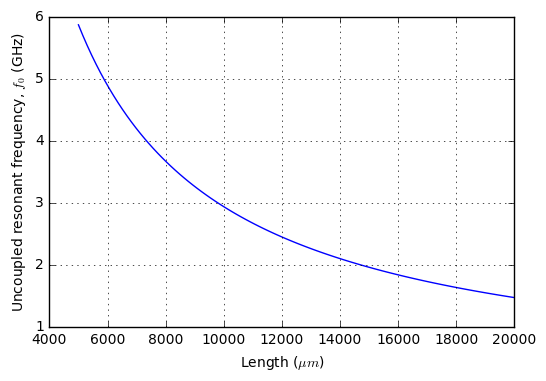

In [215]:
minLen = 5000E-6
maxLen = 20000E-6
length = np.linspace(minLen, maxLen,100)

mCPW = CPWResonator(length=length, 
                    conductorWidth=20E-6, 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=4, 
                    couplingCapacitance=10E-15, 
                    loadBoundaryCondition='Short', 
                    modes=1)

plt.plot(length*np.power(10,6), mCPW.uncoupledResonantFrequency/np.power(10,9))
plt.xlabel('Length ($\mu m$)')
plt.ylabel('Uncoupled resonant frequency, $f_0$ (GHz)') 
plt.grid()

### Uncoupled fundamental resonant frequency as a function of temperature

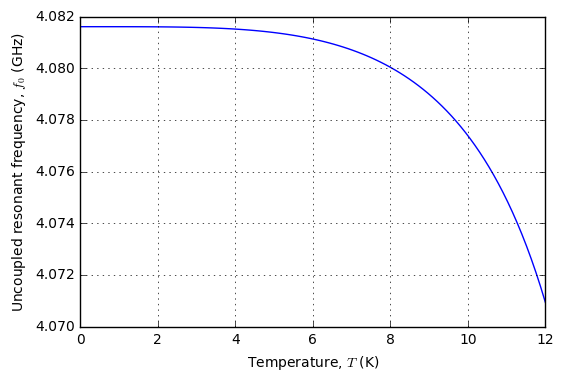

In [216]:
minTemp = 0
maxTemp = 12
temperature = np.linspace(minTemp, maxTemp,100)

mCPW = CPWResonator(length=7186E-6, 
                    conductorWidth=20E-6, 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=temperature, 
                    couplingCapacitance=10E-15, 
                    loadBoundaryCondition='Short', 
                    modes=1)

plt.plot(temperature, mCPW.uncoupledResonantFrequency/np.power(10,9))
plt.xlabel('Temperature, $T$ (K)')
plt.ylabel('Uncoupled resonant frequency, $f_0$ (GHz)') 
plt.grid()

### Coupled resonant frequency as a function of coupling capacitance

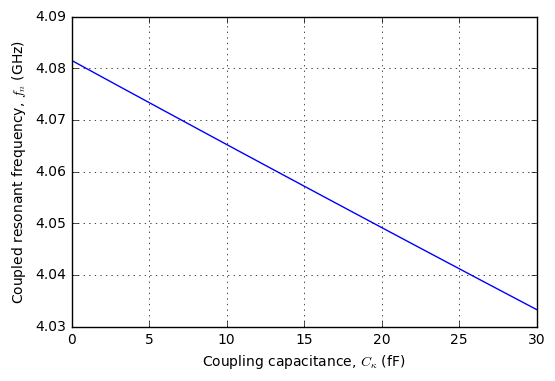

In [241]:
minCap = 0.1E-15
maxCap = 30E-15
couplingCapacitance = np.linspace(minCap, maxCap,100)

mCPW = CPWResonator(length=7186E-6, 
                    conductorWidth=20E-6, 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=4, 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition='Short', 
                    modes=1)

plt.plot(couplingCapacitance*np.power(10,15), mCPW.coupledResonantFrequency/np.power(10,9))
plt.xlabel('Coupling capacitance, $C_{\kappa}$ (fF)')
plt.ylabel('Coupled resonant frequency, $f_n$ (GHz)') 
plt.grid()

### External quality factor and insertion loss as a function of coupling capacitance

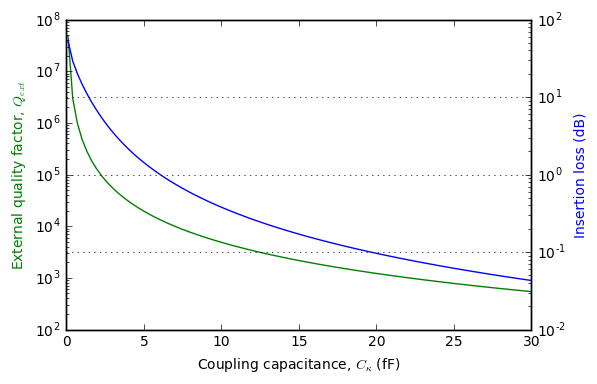

In [239]:
minCap = 0.1E-15
maxCap = 30E-15
couplingCapacitance = np.linspace(minCap, maxCap,100)

mCPWcap = CPWResonator(length=7186E-6, 
                    conductorWidth=20E-6, 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=4, 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition='Short', 
                    modes=1)

mCPWin = CPWResonator(length=7186E-6, 
                    conductorWidth=20E-6, 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=4, 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition='Short', 
                    modes=1)

fig, ax1 = plt.subplots()
plt.yscale('log')
ax2 = ax1.twinx()
ax1.plot(couplingCapacitance*np.power(10,15), mCPWcap.externalQualityFactor, 'g-', label="Quality factor")
ax2.plot(couplingCapacitance*np.power(10,15), mCPWin.insertionLoss, 'b-', label="Insertion loss")
plt.yscale('log')

ax1.set_xlabel('Coupling capacitance, $C_{\kappa}$ (fF)')
ax1.set_ylabel('External quality factor, $Q_{ext}$', color='g')
ax2.set_ylabel('Insertion loss (dB)', color='b')
plt.grid()

### External quality factor as a function of harmonic mode

/Users/alexmorgan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


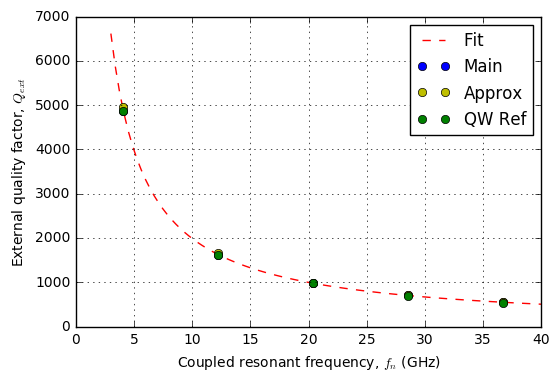

In [226]:
mCPW = CPWResonator(length=7186E-6, 
                    conductorWidth=20E-6, 
                    gapWidth=10E-6, 
                    conductorThickness=100E-9,
                    resonatorType='quarter', 
                    conductorMaterial='Niobium Nitride', 
                    substrateMaterial='Silicon',
                    temperature=4, 
                    couplingCapacitance=10E-15, 
                    loadBoundaryCondition='Short', 
                    modes=[1,2,3,4,5])

uncoupledResonantFrequency = np.linspace(3,40,100)*np.power(10,9)
externalQualityFactor = mCPW.externalQualityFactorFn(uncoupledResonantFrequency, 
                                                     mCPW.capacitancePerUnitLength, 
                                                     mCPW.length, 
                                                     mCPW.couplingCapacitance)

plt.plot(uncoupledResonantFrequency/np.power(10,9), externalQualityFactor, 'r--', label="Fit")
plt.plot(mCPW.uncoupledResonantFrequency/np.power(10,9), mCPW.externalQualityFactor, 'bo', label="Main")
plt.plot(mCPW.uncoupledResonantFrequency/np.power(10,9), mCPW.externalQualityFactorApprox, 'yo', label="Approx")
plt.plot(mCPW.uncoupledResonantFrequency/np.power(10,9), mCPW.externalQualityFactorQWref, 'go', label="QW Ref")
plt.xlabel('Coupled resonant frequency, $f_n$ (GHz)')
plt.ylabel('External quality factor, $Q_{ext}$')
plt.grid()
plt.legend()